## Einleitung  
Ziel unseres Projektes war es die IRS Steuerfiles (Steuerdaten von gemeinnützigen Organisationen in der USA) mit Pyspark auf einem Cluster eines Cloudanbieters zu verarbeiten. Die Daten liegen grundsätzlich im XML Format vor, wobei jedes File der Datensatz einer Organisation für ein Jahr enthält. Für jedes Jahr existiert ein Indexfile, das die IDs der einzelnen Files enthält. Für alle vorhandenen Jahre (ab 2011) umfasst der Datensatz ca. 120GB. Für den Download und das Mapping der teils unterschiedlichen XML Schemas in ein Pythondictionary wurde das IRSx Tool verwendet (https://github.com/jsfenfen/990-xml-reader).


## Auswahl Cloudanbieter

Im ersten Schritt musste ein geeigneter Cloudanbieter ausgewählt werden. Ein Ziel war dabei möglichst umsonst zu arbeiten und Angebote mit Pysparkintegration zu verwenden.   

| | **AWS** | **Azure** | **Google** |**Databricks**|
|---|:------------------ |:-------------------|:-------------------|:-------------------|
|Vorteile| <ul><li>Freibetrag 100 USD / Monat bei registrierten Kooperationen im Rahmen von AWS Educate (falls nicht 30 USD/Monat)</li><li>Zu analysierende Daten liegen in AWS S3</li><li>EMR als Service für Spark</li></ul>| <ul><li>+ 100 USD für 12 Monate (ohne Kreditkarte)</li><li>+ Nach Ablauf der 12 Monate neues Budget beantragbar</li><li>+ Keine Kreditkarte nötig</li><li>+ kein automatisches Belasten der Kreditkarte</li><li>+ Spark läuft auf Azure Synapse Analytics</li></ul>            | <ul><li>+ 300 USD für 90 Tage</li><li>+ keine Kreditkarte nötig</li><li>+ kein automatisches Belasten der Kreditkarte</li><li>+ Dataproc als Service für Spark (Äquivalent zu EMR in AWS)</li></ul>       | <ul><li>+kostenloser Trial mit unbegrenztem Budget</li><li>+ verfügt über optimierte Version von Spark</li><li>+ Von den ursprünglichen Entwicklern von Apache Spark</li><li>+ Integration von PowerBI für Dashboard & Reports</li></ul>|
|Nachteile| <ul><li>-Freibetrag bei registrierter Kooperation wird 31.12.21 eingestellt</li><li>-Kreditkarte notwendig, die automatisch belastet wird, wenn Grundbudget verbraucht</li><li>- EMR nicht mit kostenlosem Budget verwendbar</li></ul>     | <ul><li>Vergleichsweise geringes Budget</li></ul>           | <ul><li>-Restriktionen der Hardware Ausstattung bei begrenztem Budget</li></ul>             | <ul><li>- Nur 14 Tage kostenloser Trial</li></ul>|
 

## Kostenstruktur – Google Cloud Dataproc
$Kosten = Dataproc + Compute Engine + Speicher$  
$Dataproc = \$0.010 * \#\ of\ vCPUs * hourly duration$

Dataproc Service:  


|Setting|Configuration|
|---|---|
|Instance location|South Carolina (us-east1)|
|Master node instance|N1-standard-2 (vCPUs: 2, RAM: 7.5 GB)|
|Worker node instances|N1-standard-2 (vCPUs: 2, RAM: 7.5 GB)|
|# of normal worker nodes|3|
|Hours cluster runs per month|x|
|Storage location|South Carolina (us-east1)|
|Storage (per node)|PD 233 GiB (250GB)|
|Local SSD (per node)|0|


Rabatt ab bestimmter Stundenanzahl pro Monat für Compute Engine (500h -> 18%)  
Kein Rabatt für Speicher & Dataproc Service  

Schätzung – 1h / month:  


-Hours cluster runs per month: 1 hour -> 0,45 EUR  
-Hours cluster runs per month: 500 hour -> 195 EUR  
-https://cloud.google.com/products/calculator/#id=72fdcd7d-7a75-4333-8311-9213efc1debc  
-Max. 3 Worker Nodes waren möglich, deshalb 3   


## Architektur
Im Rahmen des Projektes haben wir Schritt für Schritt unsere Architektur optimiert, im Folgenden werden die einzelnen Versionen kurz vorgestellt.

### V1

Die IRS-Daten liegen im S3-Bucket auf AWS. Per Webrequest lädt das von uns verwendete Tool IRSx jedes XML einzeln herunter und speichert es in Unterordnern des Python-Paketes. Dies läuft aber nur lokal auf dem Master-Knoten des Clusters, sodass diese Logik nicht skaliert. Die lokal geladenen XMLs werten wir mittels des Tools aus und selektieren die für uns relevanten Daten. Diese speichern wir dann als CSV-Datei auf dem HDFS des Clusters. Durch das Abspeichern in HDFS ist sichergestellt, dass alle Nodes des Clusters Zugriff auf das File haben. Im zweiten Schritt lesen wir das CSV als PySpark Dataframe ein, wordurch dieses dann partioniert im gesamten Cluster vorliegt. Damit können dann unsere Spark-Logiken zur Auswertung skalierend und im gesamten Cluser durchgeführt werden.


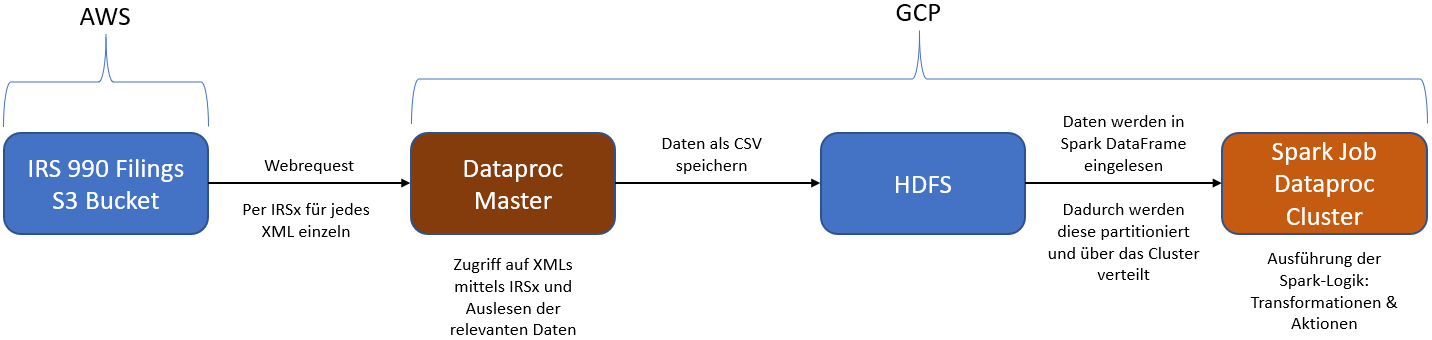

### V2

Da unsere Vorverarbeitung der Daten nicht skaliert und wir quasi die im S3 liegenden Daten nochmal doppelt in unserem HDFS abspeichern, haben wir uns entschlossen, auch diesen Teil in Spark zu integrieren und damit skalierungsfähig zu machen.

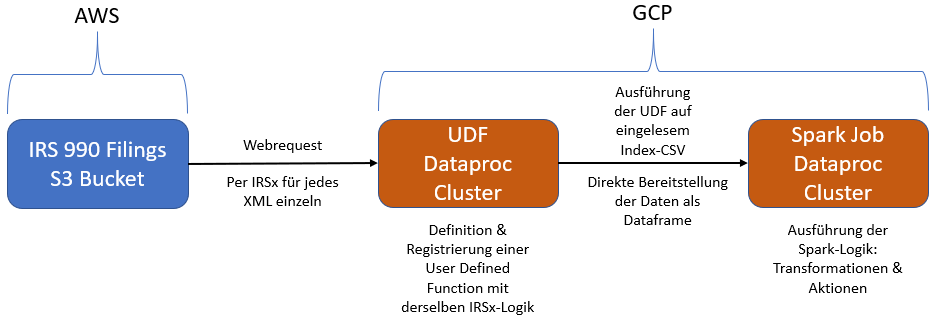

<mark>TODO</mark> ich finde hier vermischst du jetzt ein bisschen Erklärungen von den einzelnen Version und Unterschiede zwischen den beiden Version würde ich klarer trennen, das macht das verstehen denke ich einfacher

Anstatt die Vorverarbeitung der Daten nur auf dem Master-Knoten des Clusters laufen zu lassen, verteilen wir nun die Arbeitslast mittels einer User Defined Function (UDF) im ganzen Cluster. Das Coding der UDF entspricht dabei genau der Verarbeitungslogik aus V1. Die UDF muss zunächst definiert und als solche im Cluster registriert werden. Dann kann die UDF auf einem Spark-Dataframe ausgeführt werden. Das DF ist hierbei eine Index-CSV in der die ObjectIDs der einzelnen XMLs gelistet sind. Dadurch sparen wir uns die Speicherung im HDFS und können direkt aus einer Index-CSV mittels einer Transformation ein DF erstellen, mit dem wir unsere weitere Spark-Logik laufen lassen können.

In V1 haben wir also zunächst ein Index-CSV eingelesen und in einer For-Schleife seriell für jede ObjectID das entsprechende XML geladen. Dies haben wir nun skalierend im ganzen Cluster verteilt, da wir nun aus dem DF der Index-CSV mit unserer UDF, also einer Transformation des DFs, unser DF mit den relevanten Daten erstellen konnten. Damit sparen wir uns die Speicherung und das Laden im und aus dem HDFS und auch den entsprechenden Speicherplatz. Nachteilig ist hier jedoch das wir eben keinen Zwischenstand im HDFS speichern und deshalb die Transformation immer neu durchführen müssen. Beim Durchlauf mit einem größeren Datensatz könnte es also zu Verabeitungs-/Auswertungsfehlern kommen, wenn zum Beispiel relevante Schedules oder Felder nicht vorhanden sind. Damit würde dann die gesamte Verarbeitung abbrechen. Mit einer Zwischenspeicherung im HDFS hätten wir zumindest einmalig einen "sauberen" Zwischenstand, bei dem zumindest schon mal die Vorverarbeitung funktioniert hat.

Bei beiden Versionen sind auch generell die Webrequests zum S3 Bucket kritisch zu sehen. Um eine möglichst geringe Latenz zu erreichen, haben wir unser Cluster in der Region US-East aufgebaut, da dort auch das S3-Bucket liegt. Beim erstmaligen Anforderungen eines XMLs speichert das von uns verwendete Tool IRSx die XMLs in Unterordnern des Paketes. Damit ersparen wir uns zwar bei erneuten Aufrufen den Webrequest, haben hier aber auch wieder eine doppelte Datenhaltung. 

## Google Dataproc

Innerhalb der Google Cloud Platform bietet Dataproc einen Service um große Datenmengen zu verarbeiten. Dieser ist ursprünglich auf Open-Source Frameworks aufgebaut, unter anderem Apache Hadoop, Spark, Pig und Hive. Dadurch können Benutzer das gesamte bereits bekannte Ökosystem und die zugehörigen Bibliotheken der Frameworks nutzen. Dazu gehören unter anderem die im Apache-Ökosystem etablierten Sprachen Java, Scala, Python und R.

Google bewirbt Dataproc unter anderem als schneller und kostengünstig gegenüber anderen Clusteranwendungen. So kosten virtuelle CPU-Knoten lediglich 1 Cent/Stunde (s.o.) und in der Regel lassen sich Cluster in Dataproc in weniger als 90 Sekunden starten, skalieren und herunterfahren. Neben den Clusterdienst von Dataproc kann auch unaufwändig auf die anderen Dienste inenrhalb der GCP zugegriffen werden. Innerhalb des Clusters steht außerdem ein umfangreiches Monitoring und Logging der Akivitäten zur Verfügung.

Zur Verarbeitung der Datenmengen lassen sich in Dataproc Cluster erstellen. Diese lassen sich spezifisch nach Anforderung erstellen und beliebig nach Arbeitslast skalieren. In unserem Fall wurden wir jedoch von der kostenlosen Testversion eingeschränkt, die lediglich ein Maximum von acht Kernen und 1TB primären Speicherplatz zur Verfügung stellt.

## Erstellen des Clusters

Mit dem folgenden Coding lässt sich in der Shell das Cluster für unseren Anwendungsfall erstellen:

gcloud dataproc clusters create big-spark-cluster  
&emsp;--enable-component-gateway  
&emsp;--bucket sparkbucket02  
&emsp;--region us-east1  
&emsp;--zone us-east1-c  
&emsp;--master-machine-type n1-standard-2  
&emsp;--master-boot-disk-size 250  
&emsp;--num-workers 3  
&emsp;--worker-machine-type n1-standard-2  
&emsp;--worker-boot-disk-size 250  
&emsp;--image-version 2.0-debian10  
&emsp;--optional-components JUPYTER  
&emsp;--project fleet-parity-334009  



Dabei steht der Projektname für das Dataproc-übergreifende Projekt, dem das CLuster zugewiesen wird. Region und Zone wurden auf us-east festgelegt, da dort auch der AWS-Speicher mit den Steuerdaten liegt, um die Zugriffszeiten minimal zu halten. Die Image-Version beschreibt das Paket, welches das Betriebssystem, Big Data-Komponenten und Google Cloud Platform-Connectors bündelt und standartmäßig mit angegeben wird. Diese unterscheiden sich je nach Image-Version. Im Anschluss werden die Eigenschaften der Master und Worker-Knoten festgelegt sowie die Anzahl der Worker auf drei gesetzt. In beiden Fällen wird die Maschine n1-standard-2 verwendet, da diese über zwei Kerne verfügt. Zusammen mit der jeweiligen Speicherkapazität wird die Grenze der kostenlosen Testversion erreicht. Über den zugewiesenen Bucket wird ein gemeinsamer Speicher bereitgestellt sowie mittels der Komponenten das Jupyter-Notebook und das für die Verarbeitung der Steuerdaten notwendige IRSx-Packet.

## Umsetzung

Im Rahmen der Entwicklung wurden mehrere Notebooks angelegt. Dazu gehört "run_filing_20202069934930172.ipynb" mit dem beispielhaften Auslesen einer XML-Datei. Hierbei hat das Auslesen der Datei im Duchschnitt 3 ms bei einer Größe von 13 KB gedauert. Bei einer Durchschnittsgröße von ca. 30 KB ist mit einer durchschnittlichen Lesezeit pro File von 7ms. In "TestV1.ipynb" und "Test2.ipynb" ist unser Entwicklungsfortschritt zu erkennen sind. Das Notebook "2021_basic_aggregation.ipynb" bietet eine fertige Aggregation des Umsatzes der gemeinnützigen Organisationen nach dem jeweiligen Bundesstaat.

Bei der Umsetzung der Konzepte traten mehrere Schwierigkeiten auf:  
1. Fremdbibliotheken die im Code verwendet werden, der auf den Workernodes ausgeführt wird müssen dort installiert sein. Der Versuch dies über den Pyspark Context zu erreichen war erfolglos (https://spark.apache.org/docs/latest/api/python/user_guide/python_packaging.html), allerdings war es möglich bei Erstellung des Cluster die gewünschten Bibliotheken anzugeben (siehe properties beim Erstellen des Clusters). Eine Änderung von bestehenden Clustern ist nicht möglich, deswegen wurde ein neues Cluster erstellt.
2. Workernodes haben nicht direkt Zugriff auf Files die auf dem Master liegen. Ein Speichern in HDFS ermöglicht dem Cluster ein gemeinsames Arbeiten mit der Datei. Von Vorteil ist hierbei, dass HDFS von Google automatisch bei der Erstellung des Cluster von Google konfiguriert wird und nur noch das File abgelegt werden muss.
3. Google hat uns bei der Arbeit leider regelmäßig mit Fehlermeldungen überschüttet von denen weder der Ursprung noch eine Möglichkeit zur Beseitigung gefunden wurde. Hier eine Auswahl:  
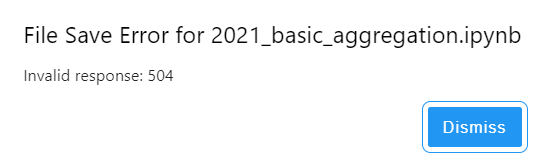
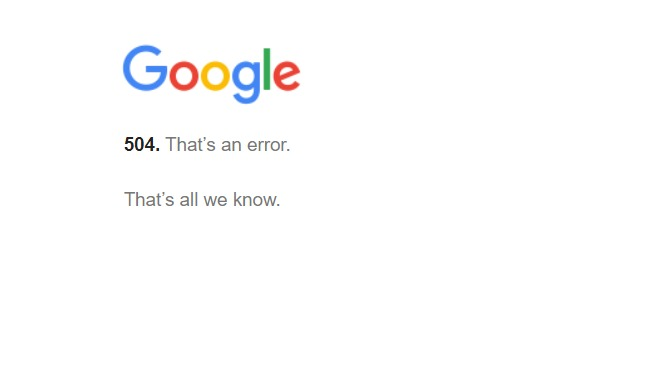
4. Es gab Berechtigungsprobleme auf den Workernodes in das Verzeichnis von IRSx zu schreiben. Um das zu fixen musste auf allen Workern folgendes Kommando ausgeführt werden: sudo chmod -R 777 /opt/conda/miniconda3/lib/python3.8/site-packages/irsx

## Skalierung

Neben dem schon betrachteten Anwendungsfall wurden weiterführend noch andere Use Cases beleuchtet, da aus Perspektive eines Analysten noch zahlreiche weitere Attribute von Relevanz sind und wir flexible und beliebige Analysen mit unserem Spark-Projekt ermöglichen möchten. Zur Lösung unseres neuen Ansatzes haben wir zwei mögliche Anwendungsfälle konzipiert. Im ersten Fall geht es um die allgemeine Skalierbarkeit unseres Projektes und im zweiten Fall wird genauer auf die funktionale Skalierung eingegangen.  

Im ersten Fall die Skalierbarkeit unseres Projekts auf Basis der Berechnungsdauer bzw. der Kosten bei gesteigerter Last bestimmt. 
Dafür haben wir einen weiteren Anwendungsfall erstellt, bei dem wir zusätzliche Attribute unserer bestehenden Analyse hinzugefügt haben - Standort (Stadt + ZIP-Code), Anzahl der Mitarbeiter, Anzahl der freiwilligen Helfer, Gewinn (Umsatz abzüglich aller Aufwendungen), Verbindlichkeiten und haben somit die Anzahl der Attribute von 5 auf 12 gesteigert. Die neuen Attribute mussten im Code neu hinzugefügt werden, wodurch der Entwicklungsaufwand bei Aufsetzen einer neuen Analyse sich recht hoch gestaltet. Da es sich als schwierig herausgestellt hat, alle Dateien eines Jahres (bzw. eines Indexfiles) in GDP zu prozessieren und der Cluster immer wieder auf Fehler gelaufen ist ohne Beschreibung der Gründe, haben wir uns dafür entschieden, anstatt der gesamten Laufzeit einer Analyse (für ein Indexfile) den Durchlauffortschritt hochzurechnen auf die Gesamtzeilenmenge.

Dieser Anwendungsfall ist im Notebook "more attributes_preprocessing.ipynb" beschrieben.

Für unseren ursprünglichen Anwendungsfall lag die Berechnungsdauer für 10.000 Datensätze bei 14 Minuten, hochgerechnet auf eine Gesamtdatenmenge von 460.000 sind das 644 Minuten (10,7 h). Gemäß der obigen Darstellung der Kostenstruktur und Nutzung des Google Price Calculators kommt man für diese Analyse auf 4,90 €.  
Währenddessen lag die Berechnungsdauer für unseren zweiten Anwendungsfall mit 12 Attributen von 10.000 Datensätzen bei 32 Minuten. Hochgerechnet auf die gesamte Anzahl eines Indexfiles wären das 1.472 Minuten (24,53 h). Diese Analyse würde 11,23 € kosten.

Somit kommt es zu einer prozentualen Steigerung der Berechnungsdauer von 129% bei Steigerung der Last um 7 Attribute (140%). Demnach skaliert unser Projekt nicht. Dies ist auch darin begründet, dass wir an die kostenlose Testversion und damit an eine maximale Anzahl von 3 Worker Nodes gebunden sind. Mit mehr Worker Nodes, müsste sich die Laufzeit proportional verkürzen und somit wäre der Anwendungsfall skalierbar. Eine gesteigerte Anzahl der Rechenknoten und gesunkene Laufzeit würde zu einer unterschiedlichen Kostenstruktur führen. Hierbei stellt sich die Frage, ob im Rahmen der kostenpflichtigen Version mehr Worker Nodes und eine kürzere Laufzeit gegebenenfalls günstiger wären.

Anwendungsfall 1:  
10.000 Zeilen &emsp; &emsp; &emsp; &emsp; &emsp; &ensp; 14 Minuten  
Hochrechnung für ein Jahr &emsp; 644 Minuten bzw. 10,7 h &emsp; 4,90€


Anwendungsfall 2:  
10.000 Zeilen &emsp; &emsp; &emsp; &emsp; &emsp; &ensp; 32 Minuten  
Hochrechnung für ein Jahr &emsp; 1.472 Minuten bzw. 24,53h	&emsp;	11,23€	
 
Als zweite Lösungsmöglichkeit haben wir uns überlegt grundlegend alle Attribute auszulesen. Dies ermöglicht eine funktionale Skalierung, da ein Analyst nicht mehr an die von uns vorausgewählten Felder gebunden ist, sondern auf den kompletten Datensatz zugreifen kann.
Hierfür wäre eine einmalige Schema-Erstellung für die Daten aus einem kompletten File notwendig. Dieses darf jedoch nicht starr aufgebaut sein, da in den ursprünglichen XML-Dateien nicht immer alle Felder gleich befüllt sind. Somit muss ein Weg gefunden werden ein flexibles Schema zu implementieren, das auch leere Werte zulässt.
Dafür muss ein repräsentativer Durchschnitt der Attributzahlen aller XML-Files gebildet werden. Aufgrund des Umfanges wird dieser Ansatz jedoch nicht näher verfolgt. Alternativ dazu kann man auch die Attributanzahl eines durchschnittlich großen XML-Files nehmen und die Anzahl der Attribute als Durchschnitt annehmen. 


## Quellen

Cloudanbieter:  
 https://www.awseducate.com/faqs?app=3#fa0P3m00000c9zOVEAY  
 https://aws.amazon.com/de/emr/  
 https://aws.amazon.com/de/free/?all-free-tier.sort-by=item.additionalFields.SortRank&all-free-tier.sort-order=asc&awsf.Free%20Tier%20Types=*all&awsf.Free%20Tier%20Categories=*all&awsm.page-all-free-tier=1   
 https://databricks.com/try-databricks?itm_data=Homepage-HeroCTA-Trial   
 https://cloud.google.com/free  
 https://azure.microsoft.com/en-us/free/students/   
 https://cloud.google.com/dataproc/v 

Dataproc:  
 https://whatis.techtarget.com/de/definition/Google-Cloud-Dataproc 17.01.2022  
 https://cloud.google.com/dataproc/docs/concepts/overview  02.02.2022  
 https://cloud.google.com/dataproc/docs/concepts/versioning/dataproc-versions 17.02.2022  